# Bayesian Optimization FashionMNIST

This example script implements Bayesian optimization for training a simple CNN on FashionMNIST. It jointly optimizes both learn rate and weight decay.

In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.distributions import constraints, transform_to
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import gpytorch
from skimage.feature import peak_local_max

from matplotlib import cm

import seaborn as sns
sns.set()

torch.manual_seed(0)
np.random.seed(0)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return correct / len(test_loader.dataset)

In [5]:
use_cuda = True

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

transform=transforms.Compose([transforms.ToTensor()])

dataset1 = datasets.FashionMNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.FashionMNIST('../data', train=False,
                    transform=transform)

In [6]:
def run(lr=3e-4, weight_decay=1e-4, batch_size=256, epochs=10, device=torch.device('cpu')):
    np.random.seed(0)
    torch.manual_seed(0)
    
    train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, num_workers=1, pin_memory=True, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, num_workers=1, pin_memory=True, shuffle=True)
    
    model = Net().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, epoch)
        acc = test(model, device, test_loader)
    
    return acc*40.

In [7]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(
            prior=gpytorch.priors.NormalPrior(torch.tensor([15., 15.]),
                                              torch.tensor([4., 4.]))
            )
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.covar_module.base_kernel.lengthscale = 3e-1
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
def train_gp(X_train, Y_train, iter_max=1000):
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_prior=gpytorch.priors.GammaPrior(concentration=0.01, rate=100.0)
        ).double()
    #likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
    #    noise=torch.ones(X_train.shape[0])*1e-4
    #    ).double().to(device)
    gp = ExactGPModel(
        X_train,
        Y_train,
        likelihood).double().to(device)
    gp.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer_gp = torch.optim.Adam(gp.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    for i in range(iter_max):
        # Zero gradients from previous iteration
        optimizer_gp.zero_grad()
        # Output from model
        output = gp(X_train)
        # Calc loss and backprop gradients
        loss = -mll(output, Y_train)
        loss.backward()
        if i % 100 == 0:
            print(f'Iter {i+1:4d}/{iter_max} - Loss: {loss.item():.4f}   lengthscale: {gp.covar_module.base_kernel.lengthscale.item():.3f}   noise: {gp.likelihood.noise[0].item():.4f}')
        optimizer_gp.step()

    gp.eval()
    likelihood.eval()
    return gp, likelihood

In [9]:
# acquisition function

def upper_confidence_bound(gp, X_, kappa=2):
    pred = gp(X_)
    return pred.mean + kappa * pred.variance.sqrt()

In [10]:
def find_candidates(gp, X_):
    with torch.no_grad():
        acq = upper_confidence_bound(gp, X_)

    acq = acq.cpu().numpy().reshape(100, 100)
    peaks = peak_local_max(acq)
    global_max = np.array(np.unravel_index(np.argmax(acq, axis=None), acq.shape)).reshape(1, -1)
    peaks = np.append(peaks, global_max, axis=0)
    peaks = np.unique(peaks, axis=0)
    peaks = np.ravel_multi_index(peaks.transpose(), acq.shape)
    
    X_init = X_[peaks]

    constraint = constraints.interval(0, 1)
    candidates = []
    expected_improvement = []

    for i in range(len(X_init[:4])):
        unconstrained_X_init = transform_to(constraint).inv(X_init[i].unsqueeze(0))
        unconstrained_X = unconstrained_X_init.clone().detach().requires_grad_(True)
        minimizer = optim.LBFGS([unconstrained_X], line_search_fn='strong_wolfe')

        def closure():
            minimizer.zero_grad()
            x = transform_to(constraint)(unconstrained_X)
            y = -upper_confidence_bound(gp, x)
            autograd.backward(unconstrained_X, autograd.grad(y, unconstrained_X))
            return y

        minimizer.step(closure)
        X = transform_to(constraint)(unconstrained_X)

        expected_improvement.append(upper_confidence_bound(gp, X).detach().cpu().item())
        candidates.append(X.detach().cpu())

    return candidates, expected_improvement

In [11]:
f = lambda lr, wd: run(lr=lr, weight_decay=wd, epochs=10, device=device)

In [12]:
# preparations

lr_init = 2e-2
wd_init = 1e-4

X = []
Y = []
lr_bounds = [-6, -1]
wd_bounds = [-6, -1]
X_lr = torch.logspace(*lr_bounds, 100, dtype=torch.double).to(device)
X_wd = torch.logspace(*wd_bounds, 100, dtype=torch.double).to(device)
XX_lr, XX_wd = torch.meshgrid(X_lr, X_wd)
X_ = torch.stack([XX_lr.reshape(-1), XX_wd.reshape(-1)]).transpose(1,0)

candidates = [
    [2e-2, 1e-3],
    #[1e-2, 1e-3],
    #[2e-2, 6e-3],
    #[1e-2, 6e-3]
]

prior_mean = 0.1  # accuracy of a random model

runs_num = 0

In [13]:
def normalize_X(X_unnorm):
    X_norm = X_unnorm.clone().log10()
    X_norm[:,0] -= lr_bounds[0]
    X_norm[:,0] /= (lr_bounds[1]-lr_bounds[0])
    
    X_norm[:,1] -= wd_bounds[0]
    X_norm[:,1] /= (wd_bounds[1]-wd_bounds[0])
    
    return X_norm

def unnormalize_X(X_norm):
    X_unnorm = X_norm.clone()
    X_unnorm[:,0] *= (lr_bounds[1]-lr_bounds[0])
    X_unnorm[:,0] += lr_bounds[0]
    
    X_unnorm[:,1] *= (wd_bounds[1]-wd_bounds[0])
    X_unnorm[:,1] += wd_bounds[0]
    
    return torch.pow(10, X_unnorm)

lr        wd        acc
0.005055  0.000956  36.872000
0.005401  0.001528  36.692000
0.005551  0.000606  36.544000
0.006008  0.001952  36.980000
Iter    1/1000 - Loss: 186.1490   lengthscale: 0.300   noise: 0.6932
Iter  101/1000 - Loss: 39.8797   lengthscale: 1.018   noise: 0.0742
Iter  201/1000 - Loss: 23.9898   lengthscale: 1.030   noise: 0.0198
Iter  301/1000 - Loss: 17.2347   lengthscale: 0.905   noise: 0.0113
Iter  401/1000 - Loss: 13.2761   lengthscale: 0.889   noise: 0.0094
Iter  501/1000 - Loss: 10.6479   lengthscale: 0.895   noise: 0.0091
Iter  601/1000 - Loss: 8.8157   lengthscale: 0.902   noise: 0.0091
Iter  701/1000 - Loss: 7.5135   lengthscale: 0.909   noise: 0.0091
Iter  801/1000 - Loss: 6.5832   lengthscale: 0.916   noise: 0.0091
Iter  901/1000 - Loss: 5.9205   lengthscale: 0.922   noise: 0.0091


<IPython.core.display.Javascript object>


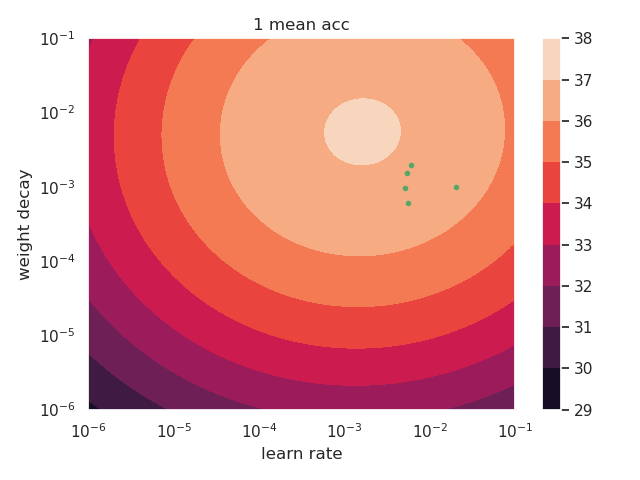

<IPython.core.display.Javascript object>


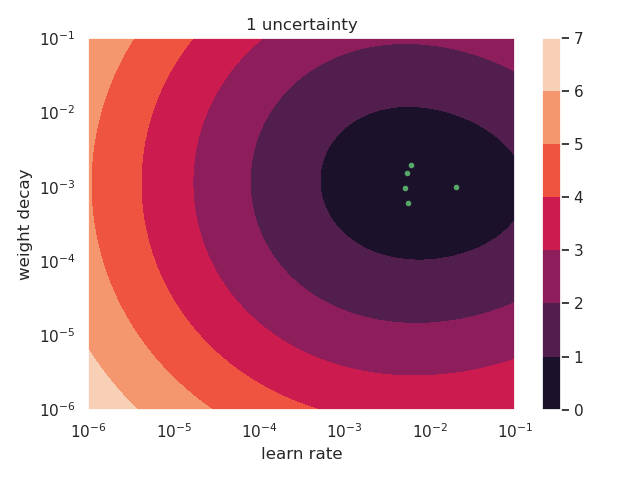

<IPython.core.display.Javascript object>


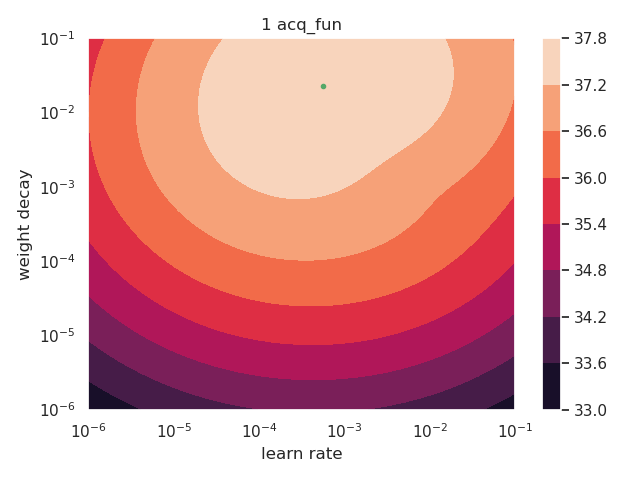

<IPython.core.display.Javascript object>


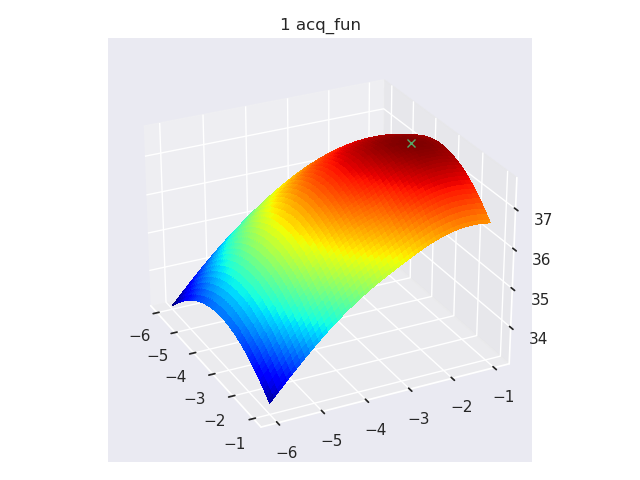

In [16]:
# first run

print("lr        wd        acc")

plt.close('all')

for candidate in candidates:
    y = f(lr=candidate[0], wd=candidate[1])
    print(f"{candidate[0]:.6f}  {candidate[1]:.6f}  {y:.6f}")
    X.append(candidate)
    Y.append(y)

X_train = torch.stack([
    torch.DoubleTensor(np.array(X)[:,0]),
    torch.DoubleTensor(np.array(X)[:,1])
]).transpose(1,0).to(device)

X_train = normalize_X(X_train)
Y_train = torch.DoubleTensor(np.array(Y)).to(device)

gp, likelihood = train_gp(X_train, Y_train)

with torch.no_grad():
    X_test = torch.stack([
        X_[:,0],
        X_[:,1]
    ]).transpose(1,0)
    X_test = normalize_X(X_test)
    candidates, expected_improvement = find_candidates(gp, X_test)
    
    candidates = torch.cat(candidates).cpu()
    candidates = torch.unique(candidates, dim=0)
    candidates = unnormalize_X(candidates).numpy()
    
    pred = gp(X_test)
    acq = upper_confidence_bound(gp, X_test)

fig1, ax1 = plt.subplots()
ln11 = ax1.contourf(XX_lr.cpu(), XX_wd.cpu(), pred.mean.cpu().reshape(100,100).numpy())
ln12 = ax1.plot(np.array(X)[:,0], np.array(X)[:,1], 'g.', label='observed')
ax1.set_title(f"{runs_num} mean acc")
fig1.colorbar(ln11, ax=ax1)
ax1.set_xlabel('learn rate')
ax1.set_ylabel('weight decay')
#ax1.set_xlim(lr_bounds)
#ax1.set_ylim(wd_bounds)
ax1.loglog()
fig1.tight_layout()
fig1.savefig(f'out/{runs_num}_fig1.pdf', bbox_inches='tight')
fig1.show()

fig2, ax2 = plt.subplots()
ln21 = ax2.contourf(XX_lr.cpu().numpy(), XX_wd.cpu().numpy(),
                   (pred.confidence_region()[1].detach().cpu().reshape(100,100)\
                    -pred.confidence_region()[0].detach().cpu().reshape(100,100)).numpy(),
                  )
ln22 = ax2.plot(np.array(X)[:,0], np.array(X)[:,1], 'g.', label='observed')
ax2.set_title(f"{runs_num} uncertainty")
fig2.colorbar(ln21, ax=ax2)
ax2.set_xlabel('learn rate')
ax2.set_ylabel('weight decay')
#ax2.set_xlim(lr_bounds)
#ax2.set_ylim(wd_bounds)
ax2.loglog()
fig2.tight_layout()
fig2.savefig(f'out/{runs_num}_fig2.pdf', bbox_inches='tight')
fig2.show()

fig3, ax3 = plt.subplots()
ln31 = ax3.contourf(XX_lr.cpu().numpy(),
                    XX_wd.cpu().numpy(),
                    acq.cpu().reshape(100,100).numpy())
ln32 = ax3.plot(candidates[:,0], candidates[:,1], 'g.', label='candidates')
ax3.set_title(f"{runs_num} acq_fun")
ax3.set_xlabel('learn rate')
ax3.set_ylabel('weight decay')
#ax3.set_xlim(lr_bounds)
#ax3.set_ylim(wd_bounds)
ax3.loglog()
fig3.colorbar(ln31, ax=ax3)
fig3.tight_layout()
fig3.savefig(f'out/{runs_num}_fig3.pdf', bbox_inches='tight')
fig3.show()

fig4, ax4 = plt.subplots(subplot_kw={"projection": "3d"})
ln41 = ax4.plot_surface(XX_lr.log10().cpu().numpy(),
                        XX_wd.log10().cpu().numpy(),
                        acq.cpu().reshape(100,100).numpy(),
                        cmap=cm.jet,
                        linewidth=0, antialiased=False)
ax4.plot(np.log10(candidates[:,0]), np.log10(candidates[:,1]), expected_improvement, 'gx')
ax4.set_title(f"{runs_num} acq_fun")
fig4.tight_layout()
fig4.savefig(f'out/{runs_num}_fig4.pdf', bbox_inches='tight')

fig4.show()

np.savez(
    f"out/{runs_num}_fig_data.npz",
    XX_lr=XX_lr.cpu().numpy(), XX_wd=XX_wd.cpu().numpy(),
    pred=pred.mean.cpu().reshape(100,100).numpy(),
    observed_X=np.array(X),
    confidence=pred.confidence_region()[1].detach().cpu().reshape(100,100)\
               -pred.confidence_region()[0].detach().cpu().reshape(100,100),
    acq=acq.cpu().reshape(100,100).numpy(),
    candidates=candidates
    )

runs_num += 1